# Distance-based statistics in `pointpats`

This notebook provides an introduction to the
**distance-based statistics** available in `pointpats`, focusing on:

- Ripley’s **G** (nearest-neighbor) function
- Ripley’s **F** (empty-space) function
- Ripley’s **K** and **L** functions (inter-event distances)
- Simulation-based **envelopes** using `g_test` and `k_test`

We will:

1. Construct two toy point patterns in the unit square: one **CSR** (completely
   spatially random) and one **clustered**.
2. Compare their distance-based statistics using the functional API:
   `f`, `g`, `k`, and `l`.
3. Use `g_test` and `k_test` to generate Monte Carlo simulation envelopes
   under CSR and visualize departures from complete spatial randomness.

This notebook is designed to live in the `docs/user-guide/` folder and be
executed automatically as part of the `pointpats` documentation build.

## 1. Setup and imports

We work in the unit square `[0, 1] × [0, 1]` and simulate patterns using
the random distributions in `pointpats.random`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pointpats import PointPattern, random
from pointpats import f, g, k, l, g_test, k_test

# Make results reproducible
np.random.seed(12345)

# Unit square hull encoded as [xmin, ymin, xmax, ymax]
hull = np.array([0.0, 0.0, 1.0, 1.0])
hull

array([0., 0., 1., 1.])

## 2. Constructing example point patterns

We construct two patterns within the same hull:

- a **CSR** pattern from a homogeneous Poisson process; and
- a **clustered** pattern from a Poisson cluster process.


In [2]:
n_points = 200

# CSR pattern: homogeneous Poisson process in the hull
coords_csr = random.poisson(hull, size=n_points)
pp_csr = PointPattern(coords_csr)

# Clustered pattern: Poisson cluster process
coords_cluster = random.cluster_poisson(
    hull,
    size=n_points,
    n_seeds=5,
)
pp_cluster = PointPattern(coords_cluster)

pp_csr.n, pp_cluster.n

(200, 200)

### Helper: plotting point patterns

We will reuse a simple helper to visualize point patterns in their hull.

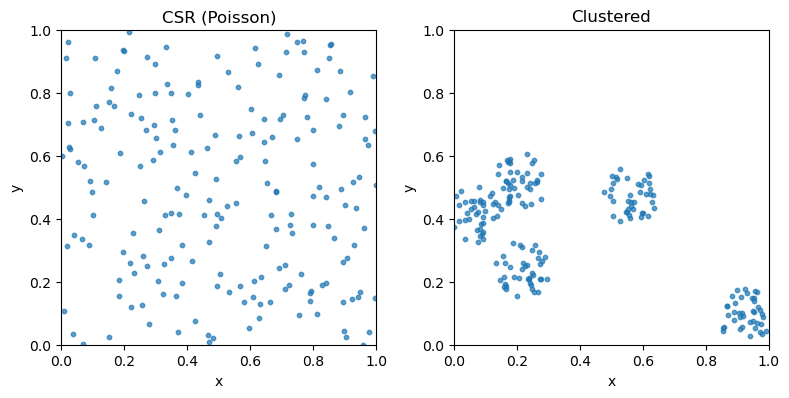

In [3]:
def plot_pattern(points, hull, ax=None, title=None):
    """Plot a 2D point pattern inside a rectangular hull.

    Parameters
    ----------
    points : array-like of shape (n, 2)
        Point coordinates.
    hull : array-like of length 4
        Bounding box [xmin, ymin, xmax, ymax].
    ax : matplotlib.axes.Axes, optional
        Axis to plot on.
    title : str, optional
        Plot title.
    """
    points = np.asarray(points)

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    xmin, ymin, xmax, ymax = hull
    ax.scatter(points[:, 0], points[:, 1], s=10, alpha=0.7)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if title:
        ax.set_title(title)

    return ax


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_pattern(coords_csr, hull, ax=axes[0], title="CSR (Poisson)")
plot_pattern(coords_cluster, hull, ax=axes[1], title="Clustered")
plt.tight_layout()
plt.show()

## 3. Distance-based summary functions: F, G, K, L

`pointpats` provides a functional API for distance-based statistics.
Each function takes `coordinates` and returns a pair `(support, values)`:

```python
support, G_vals = g(coordinates)
support, F_vals = f(coordinates, hull=hull)
support, K_vals = k(coordinates)
support, L_vals = l(coordinates, linearized=True)
```

- **G(d)**: nearest-neighbor distribution from events to events.
- **F(d)**: empty-space function from random locations to events
  (requires a hull when distances are not precomputed).
- **K(d)**: cumulative inter-event distance function.
- **L(d)**: scaled and shifted version of K; for CSR, linearized L
  should be close to zero across distances.

In [4]:
# G: nearest-neighbor distribution
support_g_csr, G_csr = g(coords_csr)
support_g_cluster, G_cluster = g(coords_cluster)

# F: empty-space function (needs hull when distances=None)
support_f_csr, F_csr = f(coords_csr, hull=hull)
support_f_cluster, F_cluster = f(coords_cluster, hull=hull)

# K: inter-event distance function
support_k_csr, K_csr = k(coords_csr)
support_k_cluster, K_cluster = k(coords_cluster)

# L: linearized version of K
support_l_csr, L_csr = l(coords_csr, linearized=True)
support_l_cluster, L_cluster = l(coords_cluster, linearized=True)

(support_g_csr.shape, support_k_csr.shape)

((20,), (20,))

### 3.1 Comparing G and F

We first compare the G and F functions for the CSR and clustered patterns.
Clustering tends to increase the probability of short distances, which is
reflected differently in G and F.

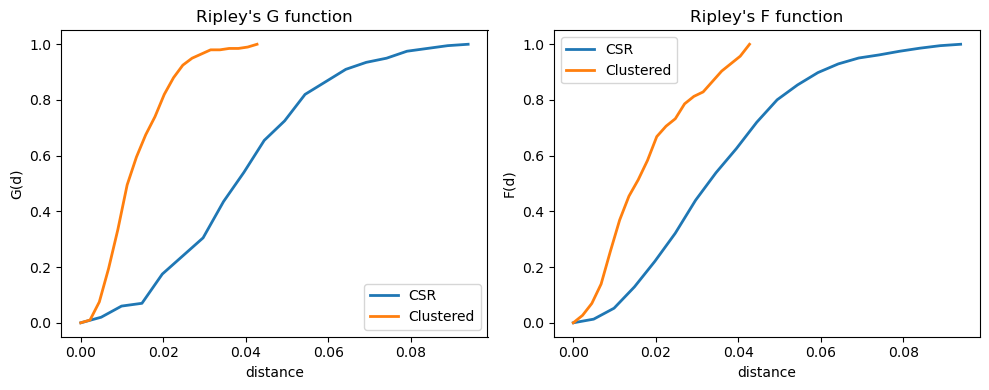

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# G function
ax = axes[0]
ax.plot(support_g_csr, G_csr, label="CSR", lw=2)
ax.plot(support_g_cluster, G_cluster, label="Clustered", lw=2)
ax.set_xlabel("distance")
ax.set_ylabel("G(d)")
ax.set_title("Ripley's G function")
ax.legend()

# F function
ax = axes[1]
ax.plot(support_f_csr, F_csr, label="CSR", lw=2)
ax.plot(support_f_cluster, F_cluster, label="Clustered", lw=2)
ax.set_xlabel("distance")
ax.set_ylabel("F(d)")
ax.set_title("Ripley's F function")
ax.legend()

plt.tight_layout()
plt.show()

### 3.2 Comparing K and L

Under complete spatial randomness (CSR) with intensity `lambda`, we expect:

- `K(d)` to grow like `pi * d^2`.
- `L(d)` (linearized) to be close to zero.

Departures above zero in L suggest clustering, while departures below zero
suggest inhibition (regularity).

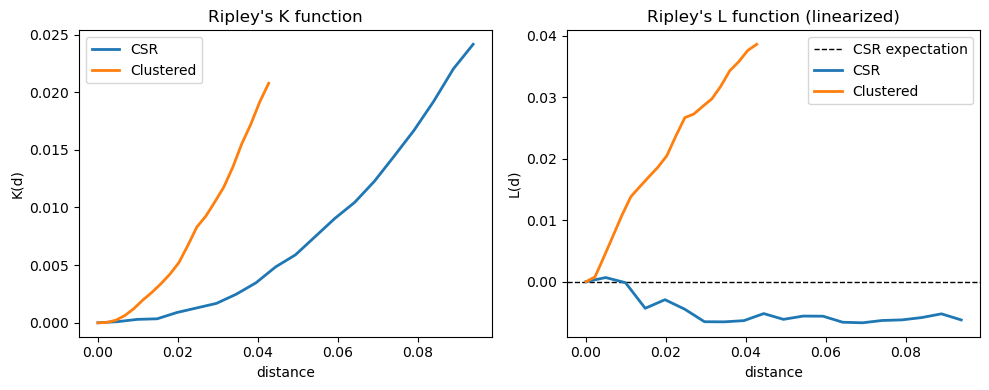

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# K function
ax = axes[0]
ax.plot(support_k_csr, K_csr, label="CSR", lw=2)
ax.plot(support_k_cluster, K_cluster, label="Clustered", lw=2)
ax.set_xlabel("distance")
ax.set_ylabel("K(d)")
ax.set_title("Ripley's K function")
ax.legend()

# L function
ax = axes[1]
ax.axhline(0.0, color="k", ls="--", lw=1, label="CSR expectation")
ax.plot(support_l_csr, L_csr, label="CSR", lw=2)
ax.plot(support_l_cluster, L_cluster, label="Clustered", lw=2)
ax.set_xlabel("distance")
ax.set_ylabel("L(d)")
ax.set_title("Ripley's L function (linearized)")
ax.legend()

plt.tight_layout()
plt.show()

## 4. Simulation envelopes with `g_test` and `k_test`

The functional API (`f`, `g`, `k`, `l`) gives a single curve for a given
pattern. To assess whether this curve is consistent with CSR, `pointpats`
provides test functions like `g_test` and `k_test` that:

1. Simulate many CSR patterns in the same hull.
2. Compute the statistic for each simulation.
3. Return the observed statistic, the simulated statistics, and Monte Carlo
   p-values at each distance.

We will apply `g_test` and `k_test` to the **clustered** pattern and visualize
the simulation envelopes.

In [7]:
n_sims = 199

g_cluster = g_test(
    coords_cluster,
    hull=hull,
    keep_simulations=True,
    n_simulations=n_sims,
)

k_cluster = k_test(
    coords_cluster,
    hull=hull,
    keep_simulations=True,
    n_simulations=n_sims,
)

g_cluster.support.shape, g_cluster.simulations.shape, k_cluster.simulations.shape

((20,), (199, 20), (199, 20))

### Helper: plotting simulation envelopes

We define a small helper that takes a test result and produces a two-panel
plot showing:

- the observed function and a simulation envelope; and
- the point pattern used in the test.

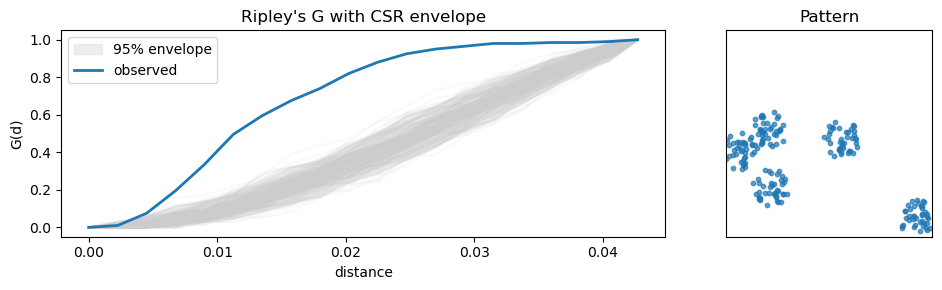

In [8]:
def plot_envelope(test_result, coordinates, name="G"):
    """Plot simulation envelopes and the observed distance function.

    Parameters
    ----------
    test_result : namedtuple
        Result from g_test, k_test, etc. Must have attributes
        `support`, `statistic`, and `simulations`.
    coordinates : array-like of shape (n, 2)
        The point pattern being tested.
    name : str, default "G"
        Name of the statistic, used for labels and titles.
    """
    support = test_result.support
    observed = test_result.statistic
    sims = test_result.simulations

    fig, axes = plt.subplots(
        1,
        2,
        figsize=(10, 3),
        gridspec_kw=dict(width_ratios=(2, 1)),
    )

    # Left: simulation envelope + observed
    ax = axes[0]

    # All simulations as faint lines
    ax.plot(support, sims.T, color="0.8", alpha=0.1)

    # 95% envelope
    lower = np.percentile(sims, 2.5, axis=0)
    upper = np.percentile(sims, 97.5, axis=0)
    ax.fill_between(
        support,
        lower,
        upper,
        color="0.9",
        alpha=0.7,
        label="95% envelope",
    )

    # Observed
    ax.plot(support, observed, lw=2, label="observed")

    ax.set_xlabel("distance")
    ax.set_ylabel(f"{name}(d)")
    ax.set_title(f"Ripley's {name} with CSR envelope")
    ax.legend()

    # Right: the pattern itself
    ax = axes[1]
    coords = np.asarray(coordinates)
    ax.scatter(coords[:, 0], coords[:, 1], s=10, alpha=0.7)
    xmin, ymin, xmax, ymax = hull
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Pattern")

    fig.tight_layout()
    plt.show()


plot_envelope(g_cluster, coords_cluster, name="G")

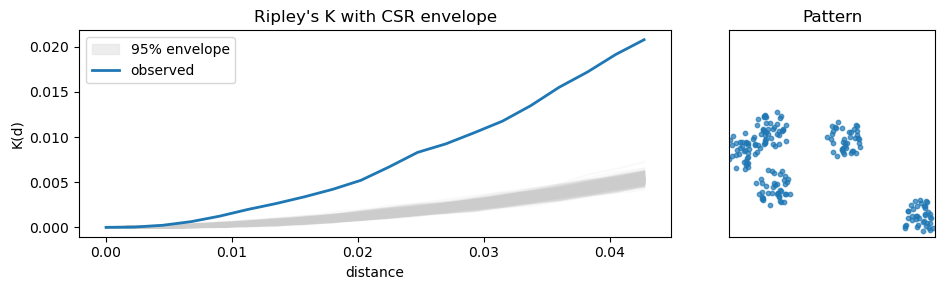

In [9]:
plot_envelope(k_cluster, coords_cluster, name="K")

In these plots, departures of the observed curve outside the simulation
envelope indicate scales (distances) where the clustered pattern is unlikely
to have arisen under CSR.

For example, if the observed G curve lies above the envelope at short
distances, that suggests an excess of close neighbors, consistent with
clustering. If it lies below, that suggests inhibition or regular spacing.


## 5. Recap

In this notebook, we have:

- Constructed **CSR** and **clustered** point patterns in a simple
  rectangular window.
- Used the functional API (`f`, `g`, `k`, `l`) to compute distance-based
  statistics directly from coordinate arrays.
- Compared how **G**, **F**, **K**, and **L** respond to CSR vs clustering.
- Used `g_test` and `k_test` to generate **simulation envelopes** under CSR
  and visualize departures from complete spatial randomness.
